In [1]:
%%capture
!pip install lime
!pip install --quiet fastai==2.4
!pip install --quiet optuna
!pip install --quiet neptune-client[optuna]
!pip install --quiet neptune-client[fastai]==2.4
!pip install json

In [2]:
from tensorflow.keras.preprocessing import image
from fastai.vision.all import *
from fastai.vision.models import xresnet
from PIL import Image as pil_image
from lime import lime_image
from skimage.segmentation import mark_boundaries



path = "/content/drive/MyDrive/All_Images"

In [3]:
learn = load_learner('/content/drive/MyDrive/ClassificationModels/densenet201_trial_1.pkl', cpu=False)

In [4]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [5]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [6]:
def rgba2rgb( rgba, img_fn, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba.astype(np.uint8)

    elif ch == 1:
        img = PILImage.create(img_fn)
        x = image2tensor(img)
        x = x .numpy()
        x = np.swapaxes(x,0,1)
        x =np.swapaxes(x,1,2)
        return np.asarray(x, dtype='uint8' )

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

In [7]:
def predict_fn(img):
    #x = img.convert('RGB')
    test_img = PILImage.create(img)
    pred_class, pred_idx, outputs = learn.predict(test_img)
    return outputs.numpy()#my_softmax(preds)

def softmax(x):
    tmp = np.zeros_like(x)
    """Compute softmax values for each sets of scores in x."""
    for i in range(x.shape[0]):
        s = np.exp(x[i, :])/np.sum(np.exp(x[i, :]))
        tmp[i, :] = s
    return tmp # only difference

def batch_predict(images):
    for i, img in enumerate(images):
        output = predict_fn(img)
        if i == 0:
            preds = output
        else:
            preds = np.concatenate((preds, output), axis=0 )
    #return softmax(preds.reshape(-1, len(dls.vocab)))
    return preds.reshape(-1, len(dls.vocab))

In [8]:
def create_gradcam(img_fn):
  img = PILImage.create(img_fn)
  x, = first(dls.test_dl([img]))

  with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    output[0,0].backward()
    grad = hookg.stored

  w = grad[0].mean(dim=[1,2], keepdim=True)
  cam_map_b = (w * act[0]).sum(0)

  with HookBwd(learn.model[0]) as hookg:
      with Hook(learn.model[0]) as hook:
          output = learn.model.eval()(x)
          act = hook.stored
      output[0,1].backward()
      grad = hookg.stored

  w = grad[0].mean(dim=[1,2], keepdim=True)
  cam_map_m = (w * act[0]).sum(0)

  fig, axs = plt.subplots(1,3, figsize=(20, 10))
  #fig.subplots_adjust(hspace = .001, wspace=.001)

  pred, _, probs = learn.predict(img)

  axs = axs.ravel()
  axs[0].imshow(img, extent = (0,224,224,0))
  axs[0].set_title("Predicted: " + pred + " ({0:2.2f}%)".format(max(probs).item()*100), size = 20)

  axs[1].imshow(cam_map_b.detach().cpu(), alpha=1, extent=(0,224,224,0), interpolation = 'hamming', cmap='magma');
  axs[1].set_title("GradCam Benign", size = 20)

  axs[2].imshow(cam_map_m.detach().cpu(), alpha=1, extent=(0,224,224,0),
                interpolation='hamming', cmap='magma');
  axs[2].set_title("GradCam Malignant", size = 20)

In [9]:
def create_lime(img_fn, num_samples = 1000, num_features = 5, pos_only = False):
  tmp_img = pil_image.open(img_fn)
  tmp_img = image.img_to_array(tmp_img)
  tmp_img = rgba2rgb(tmp_img, img_fn)

  explainer = lime_image.LimeImageExplainer()

  justifier = explainer.explain_instance(tmp_img, classifier_fn=batch_predict, num_samples=num_samples, random_seed=42)

  fig, axs = plt.subplots(1,2, figsize=(20, 10))
  #fig.subplots_adjust(hspace = .001, wspace=.001)

  axs = axs.ravel()

  pred, _, probs = learn.predict(tmp_img)
  axs[0].imshow(tmp_img, extent = (0,224,224,0))
  axs[0].set_title("Predicted: " + pred + " ({0:2.2f}%)".format(max(probs).item()*100), size = 20)

  for i in range(1):
      temp, mask = justifier.get_image_and_mask(justifier.top_labels[i], positive_only=pos_only, num_features=num_features, hide_rest=False)
      img = mark_boundaries(temp, mask)
      axs[i+1].imshow(img, extent = (0,224,224,0))
      axs[i+1].set_title(dls.vocab[justifier.top_labels[i]], size=20)
  plt.tight_layout()
  plt.show()

In [10]:
breast_us = DataBlock(
  blocks=(ImageBlock, CategoryBlock), 
  get_items=get_image_files, 
  #splitter=GrandparentSplitter('train', 'val'),
  splitter=RandomSplitter(valid_pct=.2, seed = 42),
  get_y=parent_label,
  item_tfms=Resize(512)
)

dls = breast_us.dataloaders(path, bs = 8).cuda()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



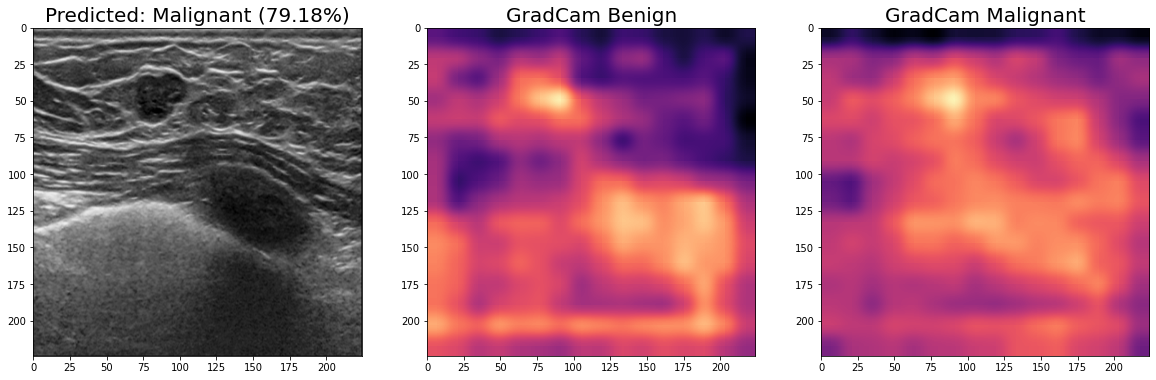

In [11]:
create_gradcam('/content/drive/MyDrive/compTest/Malignant/24.png')

  0%|          | 0/500 [00:00<?, ?it/s]

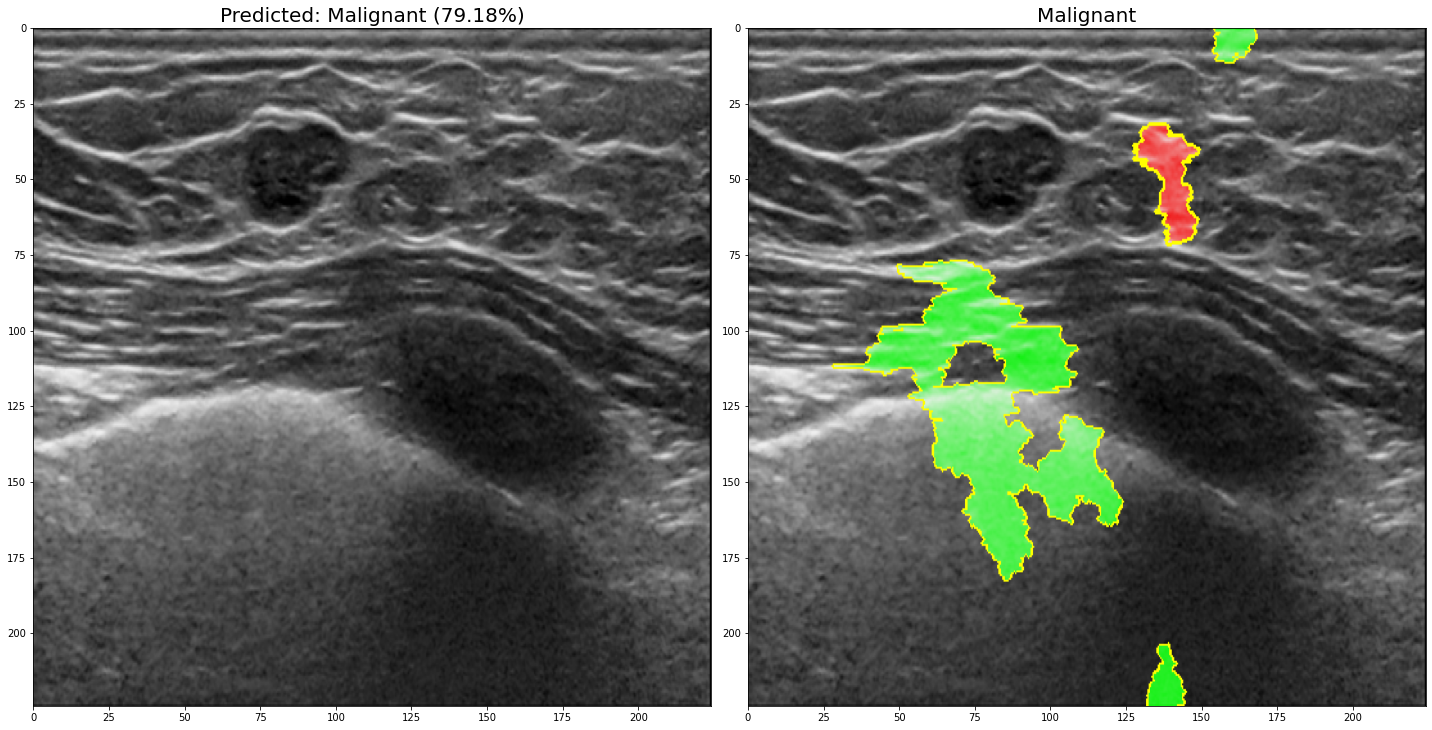

In [12]:
create_lime('/content/drive/MyDrive/compTest/Malignant/24.png', num_samples = 500, num_features = 10)